# 02 - Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime

In [2]:
sns.set_context('notebook')
sns.set_palette('deep')
import warnings
warnings.filterwarnings('ignore')

### Aux. Functions

In [3]:
def subset_flights(df, orig='all', dest='all', dDate='all', dTime='all', flight_no='all'):
    if orig != 'all':
        df = df[df['flyFrom'] == orig]
    if dest != 'all':
        df = df[df['flyTo'] == dest]
    if dDate != 'all':
        df = df[df['dDate'] == dDate]
    if dTime != 'all':
        df = df[df['dTime'] == dTime]
    if flight_no != 'all':
        df = df[df['flight_no'] == flight_no]
        
    return df

### Load data

In [4]:
flights = pd.read_csv('../data/interim/train.csv')

In [5]:
flights.head()

,collectionDate,dDate,dTime,aDate,aTime,dTimeUTC,aTimeUTC,flyFrom,flyTo,airlines,...,distance,route,price,seats,cityFrom,cityCodeFrom,cityTo,cityCodeTo,countryFrom,countryTo
0,2021-01-31 00:00:00,2021-02-01 00:00:00,15:00,2021-02-01,16:25,2021-02-01 14:00:00,2021-02-01 15:25:00,MAD,BCN,UX,...,483.25,MAD -> BCN,78,NaN,Madrid,MAD,Barcelona,BCN,Spain,Spain
1,2021-01-31 00:00:00,2021-02-01 00:00:00,09:35,2021-02-01,10:50,2021-02-01 08:35:00,2021-02-01 09:50:00,MAD,BCN,VY,...,483.25,MAD -> BCN,91,NaN,Madrid,MAD,Barcelona,BCN,Spain,Spain
2,2021-01-31 00:00:00,2021-02-01 00:00:00,19:45,2021-02-01,21:05,2021-02-01 18:45:00,2021-02-01 20:05:00,MAD,BCN,IB,...,483.25,MAD -> BCN,91,5.0,Madrid,MAD,Barcelona,BCN,Spain,Spain
3,2021-01-31 00:00:00,2021-02-01 00:00:00,19:15,2021-02-02,08:50,2021-02-01 18:15:00,2021-02-02 07:50:00,MAD,BCN,UX,...,483.25,MAD -> BCN,108,3.0,Madrid,MAD,Barcelona,BCN,Spain,Spain
4,2021-01-31 00:00:00,2021-02-01 00:00:00,14:50,2021-02-02,08:50,2021-02-01 13:50:00,2021-02-02 07:50:00,MAD,BCN,UX,...,483.25,MAD -> BCN,112,3.0,Madrid,MAD,Barcelona,BCN,Spain,Spain


In [6]:
# Data transformations needed for some visualization:
flights['orig-dest'] = flights['flyFrom'] +'-'+ flights['flyTo']
flights['airline'] = flights['airlines'].apply(lambda x: x.split(',')[0])
flights['flight_no'] = flights['airline']+''+flights['flight_no'].astype(str)

In [7]:
# Get only performed flights
departure_dates = pd.to_datetime(flights['dDate'])
max_collection_day = pd.to_datetime(flights['collectionDate']).max()                    
pf = flights[departure_dates <= max_collection_day]

### Features Overview

In [8]:
flights.columns

Index(['collectionDate', 'dDate', 'dTime', 'aDate', 'aTime', 'dTimeUTC',
       'aTimeUTC', 'flyFrom', 'flyTo', 'airlines', 'flight_no', 'fly_duration',
       'distance', 'route', 'price', 'seats', 'cityFrom', 'cityCodeFrom',
       'cityTo', 'cityCodeTo', 'countryFrom', 'countryTo', 'orig-dest',
       'airline'],
      dtype='object')

Target:
* price: Ticket price of a flight

Features:
* **collectionDate**: date flight data was taken
* **dDate**: departure day
* **dTime**: departure time
* **aDate**: arrival day
* **aTime**: arrival time
* **dTimeUTC**, **aTimeUTC**: departure and arrival time in UTC timezone
* **flyFrom**: origin airport IATA code
* **flyTo**: destination airport IATA code
* **airlines**: self-explanatory
* **flight_no**: identification plain number
* **fly_duration**, **distance**: self-explanatory
* **route**: airports through flight passes
* **seats**: availability
* **cityFrom**, **cityCodeFrom**, **cityTo**, **cityCodeTo**: different id's for the origin and destination cities
* **countryFrom**, **countryTo**: origin and dest countries

Numerical: distance, fly_duration, seats, price
\
Categorical: flyFrom, flyTo, airlines, route

In [9]:
flights[['distance', 'fly_duration', 'seats','price']].describe()

,distance,fly_duration,seats,price
count,1.266210e+06,1.266210e+06,973929.000000,1.266210e+06
mean,4.035434e+03,2.124810e+01,2.720383,3.278173e+02
std,3.617889e+03,1.248897e+01,2.420424,4.359747e+02
min,2.021800e+02,7.500000e-01,1.000000,2.000000e+01
25%,1.110280e+03,1.266667e+01,1.000000,1.030000e+02
50%,1.774110e+03,2.066667e+01,1.000000,2.420000e+02
75%,9.075770e+03,2.800000e+01,4.000000,3.840000e+02
max,1.009794e+04,6.000000e+01,8.000000,7.543700e+04


In [10]:
# TODO: comment descriptive statitics when I have final dataset

In [11]:
flights.isna().sum()

collectionDate         0
dDate                  0
dTime                  0
aDate                  0
aTime                  0
dTimeUTC               0
aTimeUTC               0
flyFrom                0
flyTo                  0
airlines               0
flight_no              0
fly_duration           0
distance               0
route                  0
price                  0
seats             292281
cityFrom               0
cityCodeFrom           0
cityTo                 0
cityCodeTo             0
countryFrom            0
countryTo              0
orig-dest              0
airline                0
dtype: int64

## Univariate Analysis

### Price

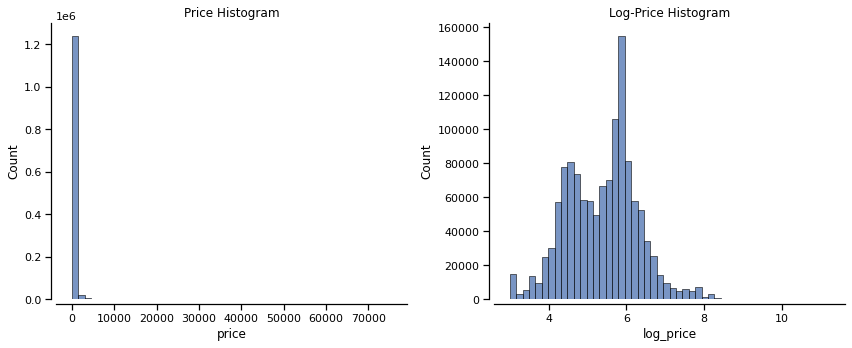

In [12]:
f, axes = plt.subplots(1, 2, figsize=(12,5))

# plot price hist
sns.histplot(x='price', data=flights, kde=False, bins=50, ax=axes[0]);
axes[0].set_title('Price Histogram')

# plot log transform price hist
flights['log_price'] = np.log(flights['price'])
sns.histplot(x='log_price', data=flights, kde=False, bins=50, ax=axes[1]);
axes[1].set_title('Log-Price Histogram')

sns.despine(offset=5)
plt.tight_layout()

* Target variable 'price' has many high values that skew to the right its distribution. So let's use log-transform.
* As we can see, 'log_price' aproximate a bit better to a normal distribution 

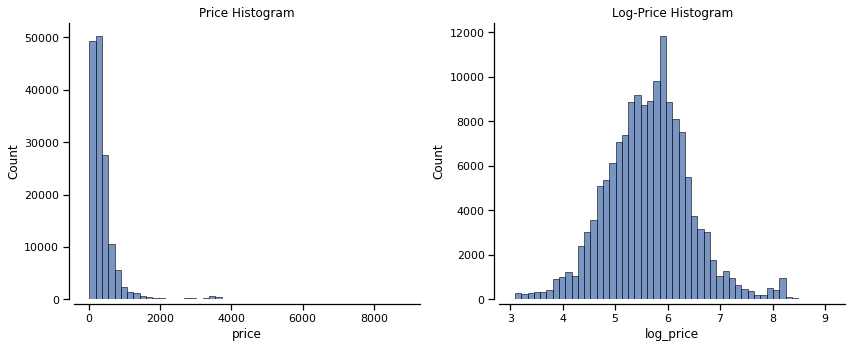

In [13]:
f, axes = plt.subplots(1, 2, figsize=(12,5))

# plot price hist
sns.histplot(x='price', data=pf, kde=False, bins=50, ax=axes[0]);
axes[0].set_title('Price Histogram')

# plot log transform price hist
pf['log_price'] = np.log(pf['price'])
sns.histplot(x='log_price', data=pf, kde=False, bins=50, ax=axes[1]);
axes[1].set_title('Log-Price Histogram')

sns.despine(offset=5)
plt.tight_layout()

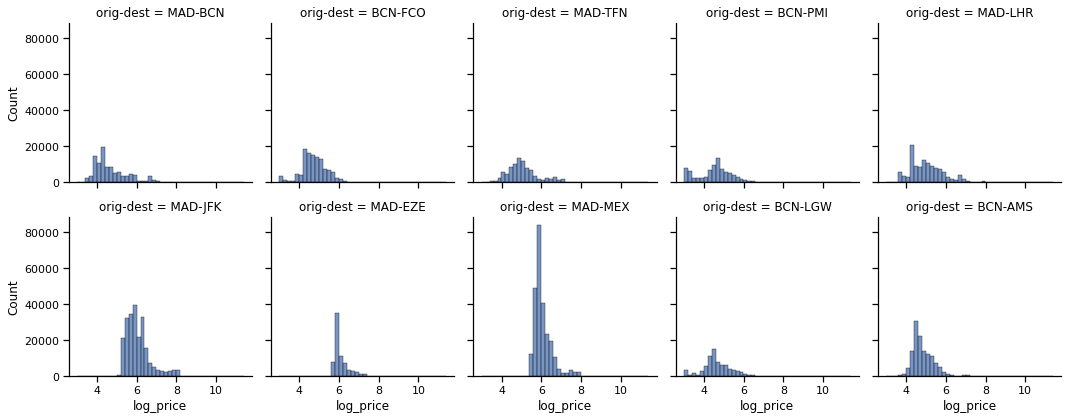

In [14]:
# Price distribution for route
sns.displot(
    flights, x="log_price", col="orig-dest", col_wrap=5, kind='hist',
    binwidth=0.2, height=3
);
plt.tight_layout()

* As we can expected, some routes are more placed to the left (cheaper routes) and other to the right (more expensive routes).
* It seems that long-distance routes as 'MAD-MEX' (Madrid-Mexico) has narrower distribution than short-distance ones. 

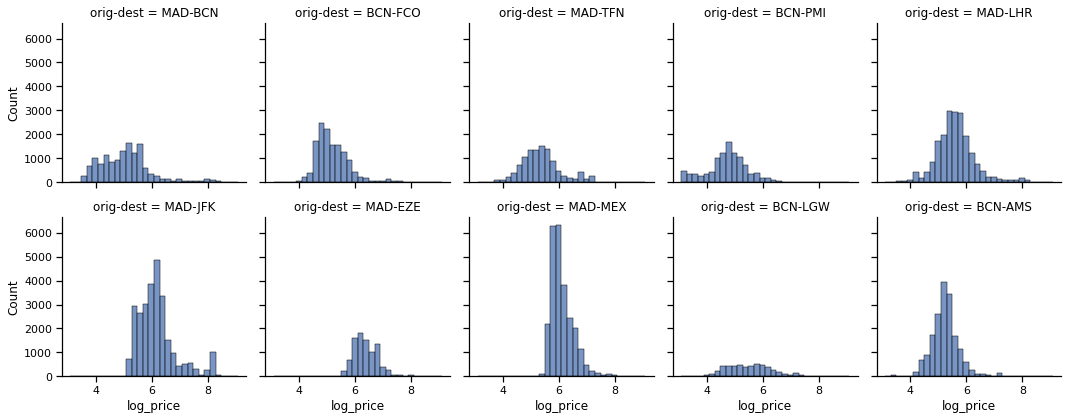

In [15]:
# Price distribution for route
sns.displot(
    pf, x="log_price", col="orig-dest", col_wrap=5, kind='hist',
    binwidth=0.2, height=3
);
plt.tight_layout()

#### Log-Price histogram by route

In [16]:
#plot_hist_price_by_route(flights, log=True);

<Figure size 1008x360 with 0 Axes>

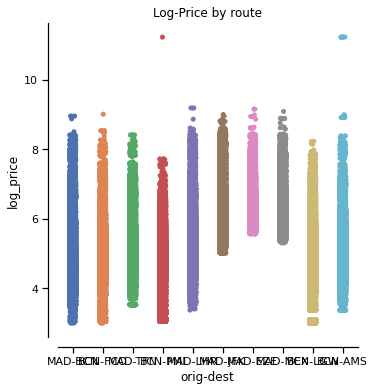

In [17]:
flights['orig-dest'] = flights['flyFrom'] +'-'+ flights['flyTo']
plt.figure(figsize=(14, 5))
sns.catplot(x='orig-dest', y='log_price', data=flights);
sns.despine(offset=10)
plt.title('Log-Price by route');

* As expected, longest routes have more expensive fares
* Many outliers

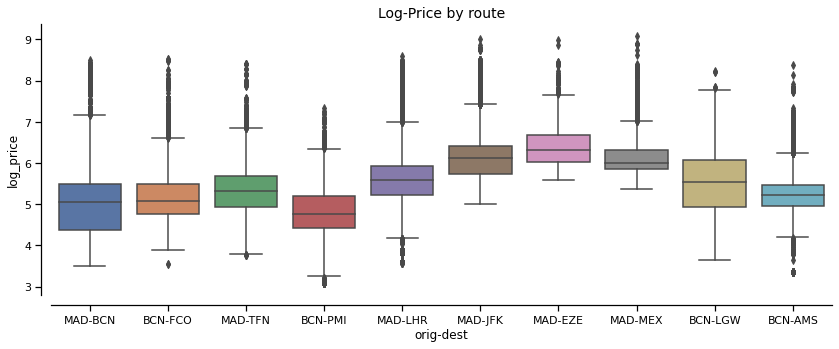

In [18]:
plt.figure(figsize=(14, 5))
sns.boxplot(x='orig-dest', y='log_price', data=pf);
sns.despine(offset=10)
plt.title('Log-Price by route', fontsize=14);

### CollectionDate

In [19]:
flights['collectionDate'].head()

0    2021-01-31 00:00:00
1    2021-01-31 00:00:00
2    2021-01-31 00:00:00
3    2021-01-31 00:00:00
4    2021-01-31 00:00:00
Name: collectionDate, dtype: object

* Day that data was collected. We can use this variable to compute a new 'Days until departure' numerical variable using this column and departure date colunm.

### FlyFrom, FlyTo

We have collected flights from 10 routes:

In [20]:
routes = flights['flyFrom'] +'-'+ flights['flyTo']

In [21]:
routes.unique()

array(['MAD-BCN', 'BCN-FCO', 'MAD-TFN', 'BCN-PMI', 'MAD-LHR', 'MAD-JFK',
       'MAD-EZE', 'MAD-MEX', 'BCN-LGW', 'BCN-AMS'], dtype=object)

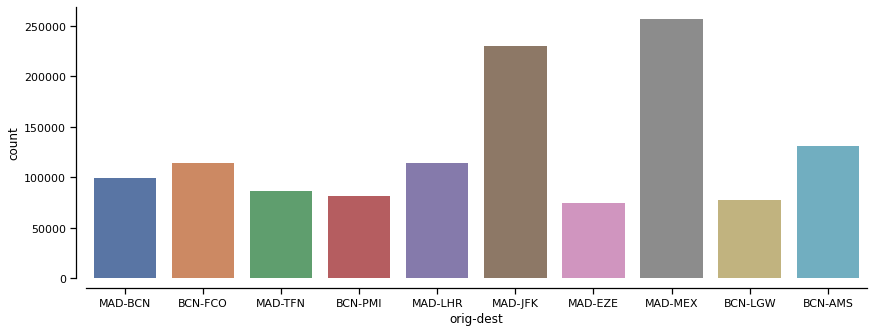

In [22]:
plt.figure(figsize=(14,5))
sns.countplot(x='orig-dest', data=flights)
sns.despine(offset=10);
plt.xticks(rotation=0);

* MAD-JFK (Madrid-New York) and MAD-MEX (Madrid-Mexico City) are the busiest routes. The rest of them have a similar traffic.
* Maybe we can add a new categorical variable with the route. 

In [23]:
# group by flight
pf_agg = pf.groupby(['orig-dest','dDate', 'dTime', 'aTime', 'flight_no'])[['log_price']].mean().reset_index()

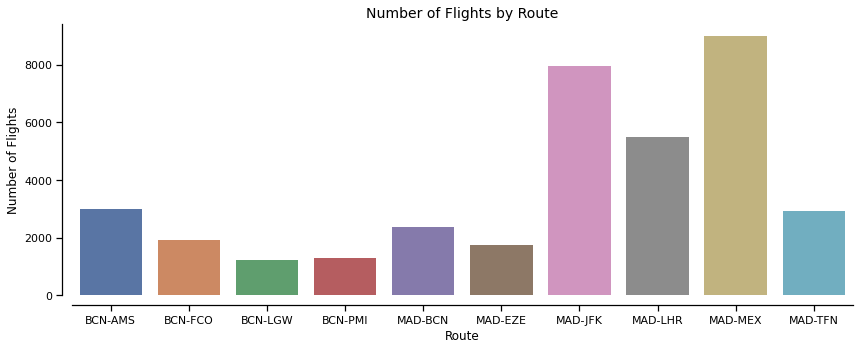

In [24]:
plt.figure(figsize=(14,5))
sns.countplot(x='orig-dest', data=pf_agg)
sns.despine(offset=10);
plt.title('Number of Flights by Route', fontsize=14)
plt.xlabel('Route')
plt.ylabel('Number of Flights')
plt.xticks(rotation=0);

### Airlines

In [25]:
flights[['airlines', 'route']]

,airlines,route
0,UX,MAD -> BCN
1,VY,MAD -> BCN
2,IB,MAD -> BCN
3,UX,MAD -> BCN
4,UX,MAD -> BCN
...,...,...
1266205,TP,BCN->LIS->FCO
1266206,UX,BCN->MAD->FCO
1266207,UX,BCN->MAD->FCO
1266208,TP,BCN->LIS->FCO


* Airlines column show the carrier that manage a given flight. Hopping flights have more than one airline.

In [26]:
flights['airline'].nunique()

131

There are 131 airlines in our dataset. Let's plot the top 40 busiest airline.

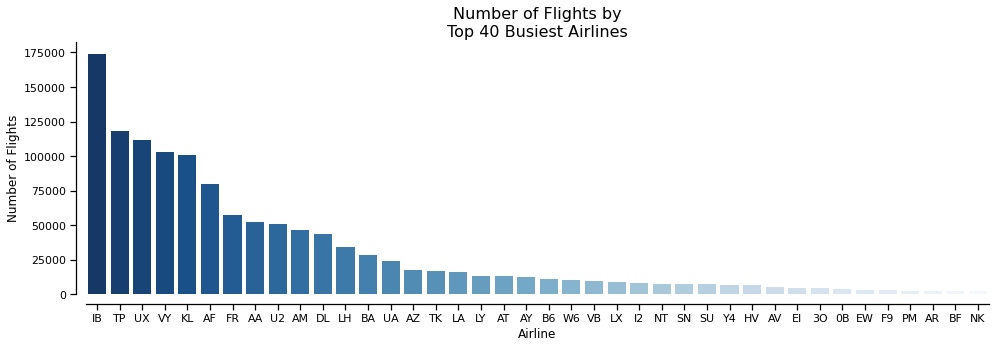

In [27]:
airlines_counts = flights.groupby('airline')['airline'].count()
busiest_airlines = airlines_counts.sort_values(ascending=False).head(40)

# plot
plt.figure(figsize=(14,5))
sns.barplot(x=busiest_airlines.index, y=busiest_airlines, palette='Blues_r')
plt.title('Number of Flights by\nTop 40 Busiest Airlines', fontsize=16)
plt.xlabel('Airline');
plt.ylabel('Number of Flights')
sns.despine(offset=10)
plt.tight_layout()

In [28]:
# group by flight
pf_agg = pf.groupby(['orig-dest','dDate', 'dTime', 'aTime', 'flight_no', 'airline'])[['log_price']].mean().reset_index()

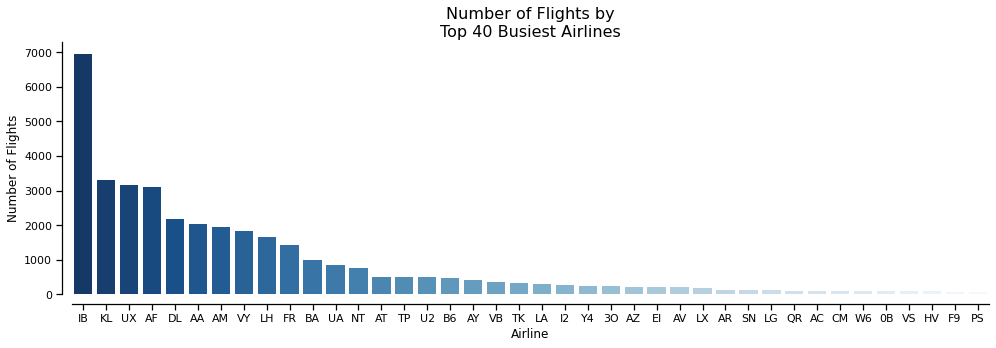

In [29]:
airlines_counts = pf_agg.groupby('airline')['airline'].count()
busiest_airlines = airlines_counts.sort_values(ascending=False).head(40)

# plot
plt.figure(figsize=(14,5))
sns.barplot(x=busiest_airlines.index, y=busiest_airlines, palette='Blues_r')
plt.title('Number of Flights by\nTop 40 Busiest Airlines', fontsize=16)
plt.xlabel('Airline');
plt.ylabel('Number of Flights')
sns.despine(offset=10)
plt.tight_layout()

### Flight_no

In [30]:
pf['flight_no'].head()

0    UX7703
1    VY1003
2    IB1946
3    UX6097
4    UX6067
Name: flight_no, dtype: object

* flight_no identifies a unique plain. Using this variable we can show price evolution a concrete flight through days. For example:

In [31]:
pf['flight_no'].nunique()

2902

In [32]:
pf.groupby('flight_no')['orig-dest'].nunique().describe()

count    2902.000000
mean        1.649897
std         1.131221
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         9.000000
Name: orig-dest, dtype: float64

Each plain travels through an average of 1.64 routes. This means that there are plains transiting more than one route.

### Fly_duration

In [33]:
flights['fly_duration'].head()

0     1.416667
1     1.250000
2     1.333333
3    13.583333
4    18.000000
Name: fly_duration, dtype: float64

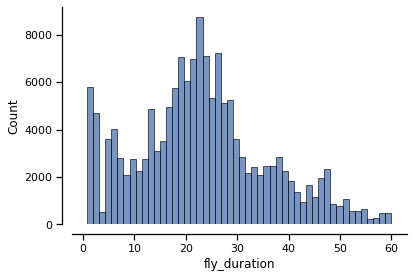

In [34]:
sns.histplot(pf['fly_duration'], bins=50);
sns.despine(offset=10)

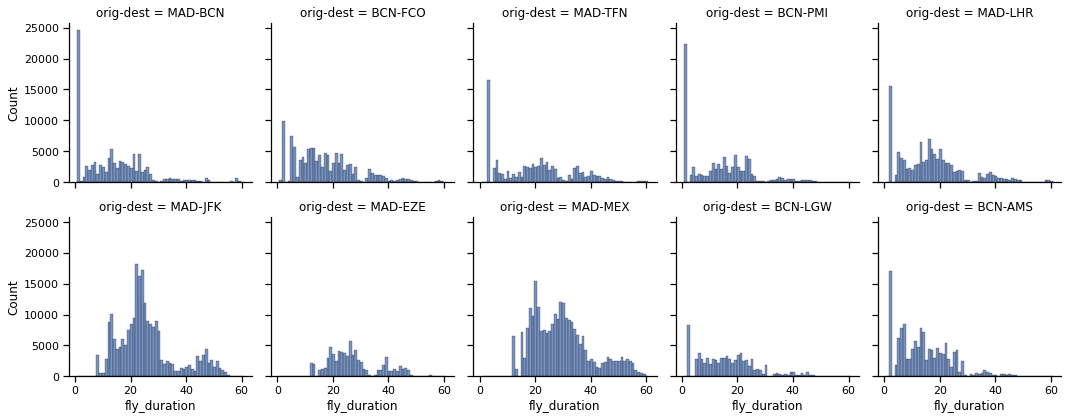

In [35]:
# Price distribution for route
sns.displot(
    flights, x="fly_duration", col="orig-dest", col_wrap=5, kind='hist',
    binwidth=1, height=3
);
plt.tight_layout()

* It seems that there are variability in the fly_duration variable even in flights on the same route.
* We can notice that in some routes a considerable number of flights concentreates in some point on the left side. These are probable direct flights.

In [36]:
# Direct flights
flights['hops'] = flights['route'].apply(lambda x: len(x.split('->')) - 2)
flights['direct'] = flights['hops'] == 0

In [37]:
# There are observations with wrong column due an error during collection. We'll drop them.

split_date = datetime.strptime('2021-02-24', '%Y-%m-%d')
broken = pd.to_datetime(flights['collectionDate']) < split_date

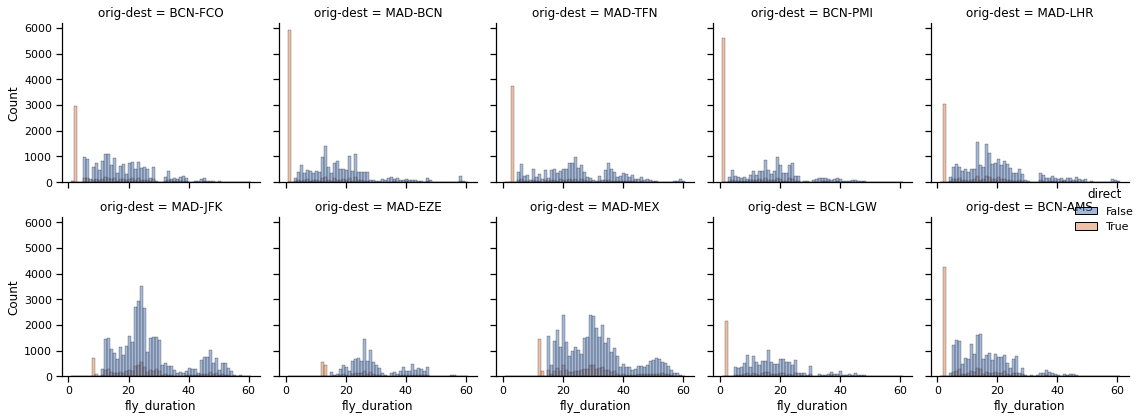

In [38]:
# Price distribution for route
g = sns.displot(
    flights[~broken], x="fly_duration", col="orig-dest", col_wrap=5, kind='hist',
    binwidth=1, height=3, hue='direct', facet_kws={"legend_out": True}
);
plt.tight_layout()

* Now we can clearly distinguish between direct flights and flights with hopping in the fly_duration distributions now

### Distance

In [39]:
flights['distance'].unique()

array([  483.25,   847.82,  1774.11,   202.18,  1245.76,  5767.2 ,
       10097.94,  9075.77,  1110.28,  1242.46])

* Distance is fixed for each route. It is the geographical distance between the two airports.

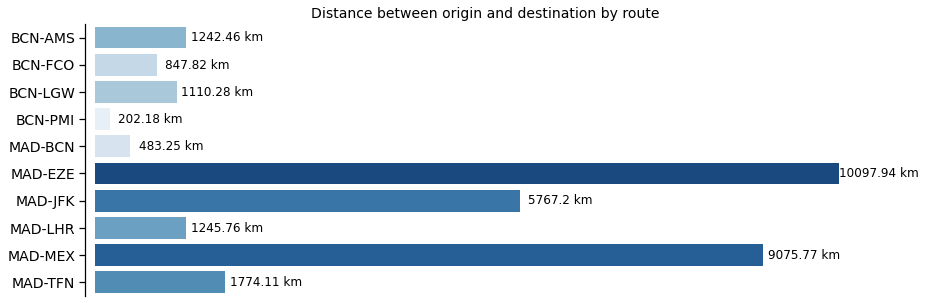

In [40]:
route_distances = pf.groupby('orig-dest')['distance'].mean().reset_index()
pal = sns.color_palette("Blues_r", len(route_distances))
rank = route_distances["distance"].argsort().argsort() 

plt.figure(figsize=(14,5))
g = sns.barplot(y='orig-dest', x='distance', data=route_distances, palette=np.array(pal[::-1])[rank]);

# values text
for index, row in route_distances.iterrows():
    g.text(row['distance']+550, index+0.13, str(round(row['distance'],2))+' km' , color='black', ha="center")

plt.title('Distance between origin and destination by route', fontsize=14)
sns.despine(offset=10, bottom=True)

# remove x axis
plt.xticks([])
plt.xlabel(None)
plt.ylabel(None)

# scale y ticks
plt.yticks(fontsize=14);

### Route

In [41]:
# TODO: route col broken in flights collected before 24 feb. USE airlines length-1 instead

In [42]:
flights['route']

0             MAD -> BCN
1             MAD -> BCN
2             MAD -> BCN
3             MAD -> BCN
4             MAD -> BCN
               ...      
1266205    BCN->LIS->FCO
1266206    BCN->MAD->FCO
1266207    BCN->MAD->FCO
1266208    BCN->LIS->FCO
1266209    BCN->LIS->FCO
Name: route, Length: 1266210, dtype: object

* This variable shows the hops in a flight route between origin and destination
* We can use this to create a new columns that computes the number of hops

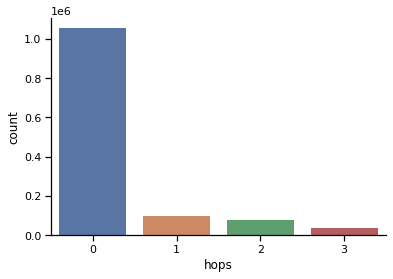

In [43]:
sns.countplot(flights['hops']);
sns.despine(trim=False, offset=0)

### Seats

In [44]:
flights['seats'].isna().sum()

292281

In [45]:
flights['seats'].isna().sum() / flights.shape[0]

0.2308313786812614

* This column has many NaN values (21.19%)

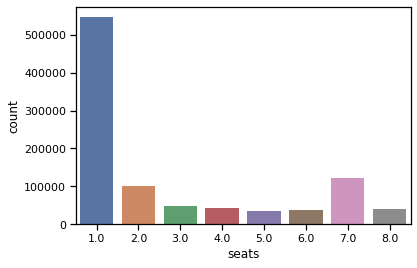

In [46]:
sns.countplot(flights['seats']);

## collectionDate and daysToDep

We can use 'collectionDate' column to compute days until the flight departure. This would be a new numerical variable.

In [47]:
collected = pd.to_datetime(flights['collectionDate'])
departure =  pd.to_datetime(flights['dDate'])

daysUntilDep = departure - collected
daysUntilDep = daysUntilDep.apply(lambda x: str(x).split()[0])

In [48]:
flights['daysUntilDep'] = daysUntilDep.astype(int)

In [49]:
collected = pd.to_datetime(pf['collectionDate'])
departure =  pd.to_datetime(pf['dDate'])

daysUntilDep = departure - collected
daysUntilDep = daysUntilDep.apply(lambda x: str(x).split()[0])
pf['daysUntilDep'] = daysUntilDep.astype(int)

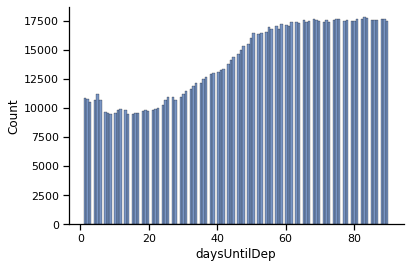

In [50]:
sns.histplot(flights['daysUntilDep']);
sns.despine()

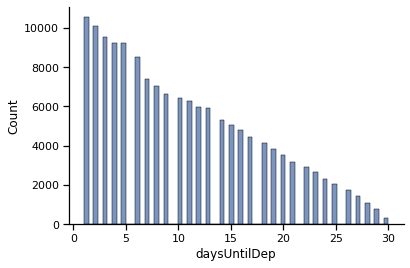

In [51]:
sns.histplot(pf['daysUntilDep']);
sns.despine()

## Multivariate Analysis

In [52]:
corr_mat = flights.corr()
corr_mat['log_price'].sort_values(ascending=False)

log_price       1.000000
price           0.711591
distance        0.663052
fly_duration    0.442167
hops            0.099310
direct         -0.048534
seats          -0.073404
daysUntilDep   -0.097243
Name: log_price, dtype: float64

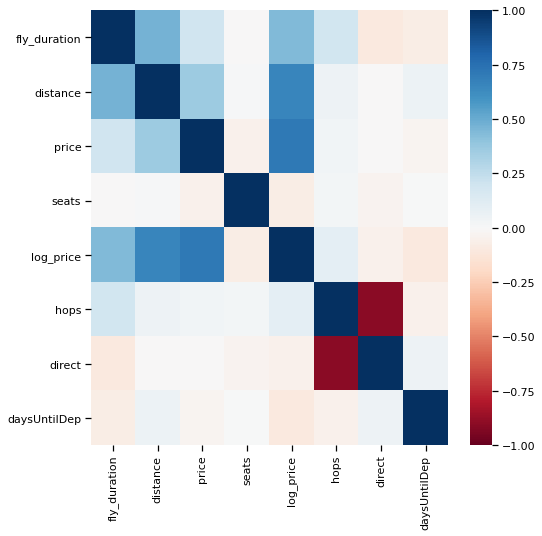

In [53]:
plt.figure(figsize=(8,8))
sns.heatmap(corr_mat, vmin=-1, vmax=1, cmap='RdBu', annot=False);

In [54]:
corr_mat = pf.corr()
corr_mat['log_price'].sort_values(ascending=False)

log_price       1.000000
price           0.789187
distance        0.556749
fly_duration    0.413789
seats           0.105793
daysUntilDep   -0.296162
Name: log_price, dtype: float64

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]),
 [Text(0, 0.5, 'fly_duration'),
  Text(0, 1.5, 'distance'),
  Text(0, 2.5, 'price'),
  Text(0, 3.5, 'seats'),
  Text(0, 4.5, 'log_price'),
  Text(0, 5.5, 'daysUntilDep')])

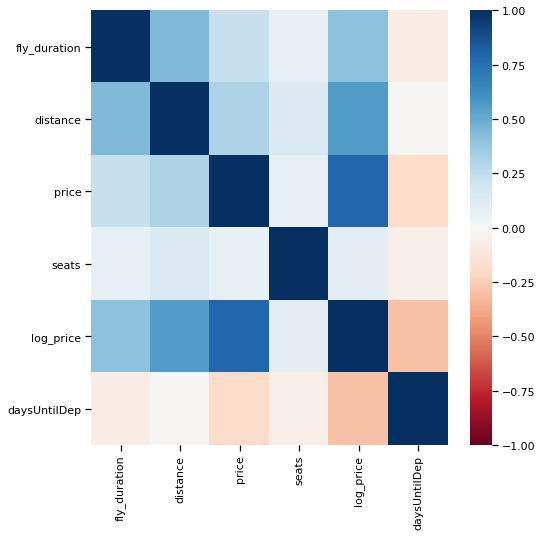

In [55]:
plt.figure(figsize=(8,8))
sns.heatmap(corr_mat, vmin=-1, vmax=1, cmap='RdBu', annot=False);
plt.yticks(rotation=0)

### Price-CollectionDate

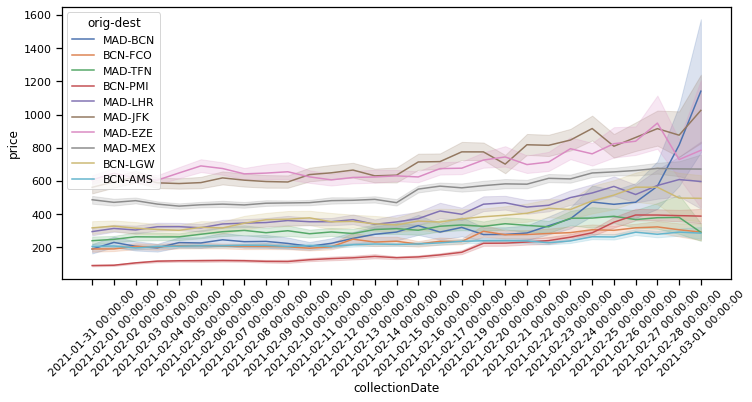

In [56]:
plt.subplots(figsize=(12,5))
sns.lineplot(x='collectionDate', y='price', data=pf, hue='orig-dest');
plt.xticks(rotation=45);

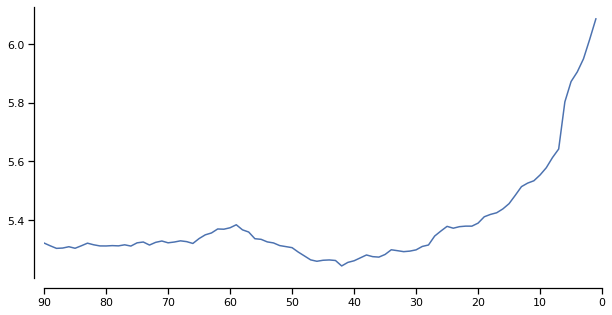

In [57]:
# mean price by remaining days to departure
grouped= flights.groupby('daysUntilDep')['log_price'].mean()
plt.figure(figsize=(10,5))
plt.plot(grouped);
plt.xlim(grouped.index.max(), 0);
sns.despine(offset=10)


* The mean price start to decrease around two month before flight departure, reach its minimum at one month, and start increasing two/three weeks before departure.

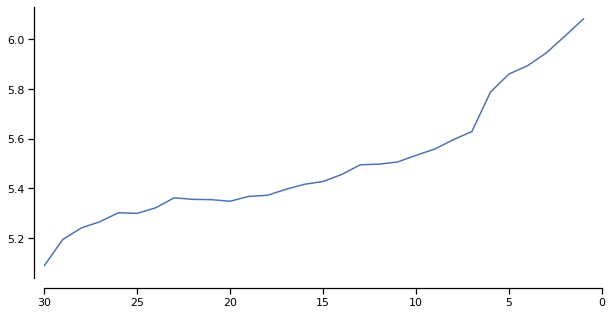

In [58]:
grouped= pf.groupby('daysUntilDep')['log_price'].mean()
plt.figure(figsize=(10,5))
plt.plot(grouped);
plt.xlim(grouped.index.max(), 0);
sns.despine(offset=10)

TypeError: unhashable type: 'numpy.ndarray'

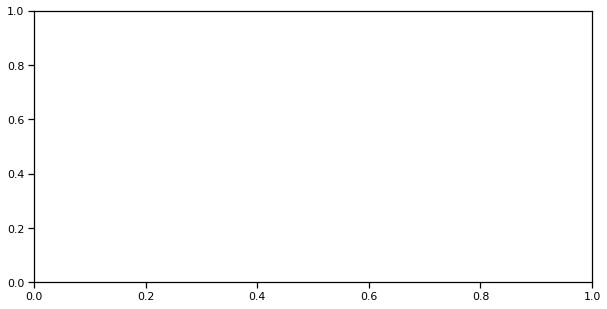

In [59]:
grouped = flights.groupby(['collectionDate','orig-dest','dDate', 'dTime', 'aTime', 'flight_no'])[['log_price']].mean().reset_index()

plt.figure(figsize=(10,5))
plt.plot(grouped);
plt.xlim(grouped.index.max(), 0);
sns.despine(offset=10)

In [ ]:
# mean price by remaining days to departure
flights[]
flights['hoursUntilDep'] = flights['daysUntilDep']

grouped= flights.groupby('hoursUntilDep')['log_price'].mean()
plt.plot(grouped);
plt.xlim(grouped.index.max(), 0);

In [ ]:
flights['flight_no'].head()

In [ ]:
flights_sample = subset_flights(flights, flight_no='UX7703')
grouped= flights_sample.groupby('daysUntilDep')['price'].mean()
plt.plot(grouped);
plt.xlim(grouped.index.max(), 0);

## Price-Distance

In [ ]:
sns.scatterplot(x='distance', y='log_price', data=flights);

In [ ]:
grouped = flights.groupby(['dDate', 'dTime'])[['distance','log_price']].mean()
sns.scatterplot(x='distance', y='log_price', data=grouped, alpha=0.9);

* Here we can see how price increases by distance.

## Price-Airlines

In [ ]:
competition = pf.groupby(['flyFrom','flyTo','dDate'])['airline'].nunique().reset_index()
competition.columns = ['flyFrom','flyTo','dDate', 'competition'] 

In [ ]:
merged = pd.merge(pf, competition, on=['dDate', 'flyFrom', 'flyTo'])

In [ ]:
sns.histplot(merged['competition'], bins=50);

In [ ]:
# Fly duration distribution for route
sns.displot(
    merged, x="competition", col="orig-dest", col_wrap=5, kind='hist',
    binwidth=1, height=3
);
plt.tight_layout()

In [ ]:
grouped = merged.groupby(['flyFrom', 'flyTo','dDate', 'dTime', 'aTime', 'airline'])[['competition', 'log_price']].mean().reset_index()

## Price-Seats

## Exploring dataset with new features from Data Preprocessing Notebook

In [78]:
df = pd.read_csv('../data/processed/train_processed.csv')

In [79]:
df.head()

,id,flyFrom,flyTo,orig-dest,dDate,day_of_month,day_of_week,fly_duration,distance,days_until_dep,session,airline,hops,direct,competition,price,log_price,hist_prices,waiting_days,buy
0,134,MAD,BCN,MAD-BCN,2021-02-01,1,Monday,1.416667,483.25,1,morning,UX,0,True,6,78,4.356709,"[78.0, nan, nan, nan, nan, nan, nan, nan, nan,...",0,0
1,124,MAD,BCN,MAD-BCN,2021-02-01,1,Monday,1.250000,483.25,1,morning,VY,0,True,6,91,4.510860,"[91.0, nan, nan, nan, nan, nan, nan, nan, nan,...",0,0
2,139,MAD,BCN,MAD-BCN,2021-02-01,1,Monday,1.333333,483.25,1,evening,IB,0,True,6,91,4.510860,"[91.0, nan, nan, nan, nan, nan, nan, nan, nan,...",0,0
3,137,MAD,BCN,MAD-BCN,2021-02-01,1,Monday,13.583333,483.25,1,evening,UX,0,True,6,108,4.682131,"[108.0, nan, nan, nan, nan, nan, nan, nan, nan...",0,0
4,132,MAD,BCN,MAD-BCN,2021-02-01,1,Monday,18.000000,483.25,1,morning,UX,0,True,6,112,4.718499,"[112.0, nan, nan, nan, nan, nan, nan, nan, nan...",0,0


In [6]:
df.shape

(115484, 19)

In [7]:
df.columns

Index(['flyFrom', 'flyTo', 'orig-dest', 'dDate', 'day_of_month', 'day_of_week',
       'fly_duration', 'distance', 'days_until_dep', 'session', 'airline',
       'hops', 'direct', 'competition', 'price', 'log_price', 'hist_prices',
       'waiting_days', 'buy'],
      dtype='object')

In [9]:
grouped = df.groupby(['orig-dest', 'airline'])

In [21]:
price_by_airline = grouped['price'].agg(['mean', 'median']).sort_values(by='median').reset_index()

In [22]:
price_by_airline[price_by_airline['orig-dest'] == 'MAD-BCN']

,orig-dest,airline,mean,median
5,MAD-BCN,I2,108.000000,91.0
8,MAD-BCN,UX,127.919814,103.0
12,MAD-BCN,IB,171.166608,120.0
13,MAD-BCN,FR,231.448468,122.0
23,MAD-BCN,VY,182.704518,149.0
27,MAD-BCN,RO,158.500000,158.5
31,MAD-BCN,LX,637.833333,171.5
32,MAD-BCN,W6,227.600000,172.0
33,MAD-BCN,3O,209.228571,173.0
40,MAD-BCN,TP,224.338542,185.0


In [ ]:
grouped = df.groupby(['orig-dest', 'airline', 'session'])
prices = grouped['waiting_days'].agg(['count','mean', 'median']).reset_index()
prices[prices['orig-dest'] == 'MAD-BCN']

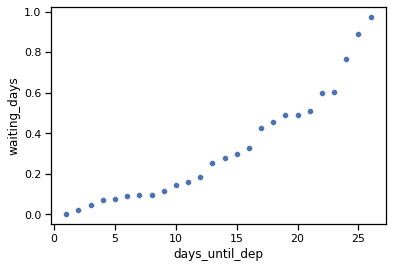

In [53]:
grouped = df.groupby(['days_until_dep'])['waiting_days'].mean().reset_index()
sns.scatterplot('days_until_dep', 'waiting_days', data=grouped);

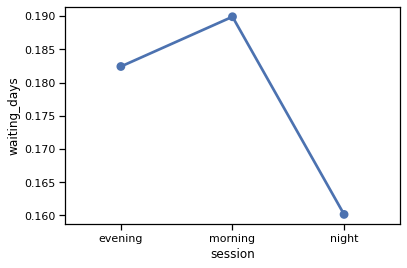

In [62]:
grouped = df.groupby(['session'])['waiting_days'].mean().reset_index()
sns.pointplot('session', 'waiting_days', data=grouped);

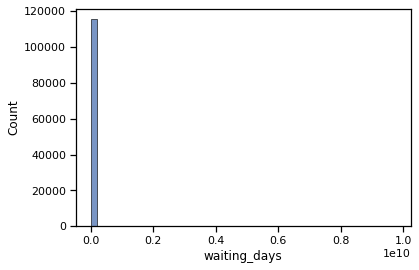

In [69]:
sns.histplot(np.exp(df['waiting_days']), bins=50);

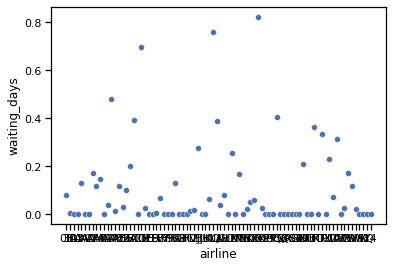

In [64]:
grouped = df.groupby(['airline'])['waiting_days'].mean().reset_index()
sns.scatterplot('airline', 'waiting_days', data=grouped);

In [81]:
df['mean_price'] = df.groupby('id')['price'].transform('min')
df['median_price'] = df.groupby('id')['price'].transform('median')
df['diff_price'] = df['price'] - df['median_price']

In [88]:
df.groupby('id')['price'].count()

id
0        1
1        1
2        1
3        1
4        1
        ..
28940    1
28941    1
28942    3
28943    5
28944    4
Name: price, Length: 28945, dtype: int64

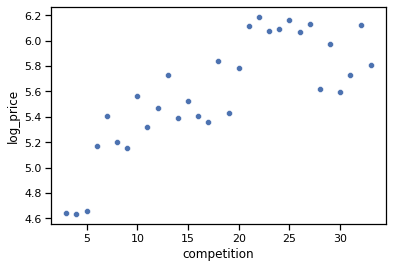

In [97]:
grouped= df.groupby('competition')['log_price'].mean().reset_index()
sns.scatterplot(x='competition', y='log_price', data=grouped);

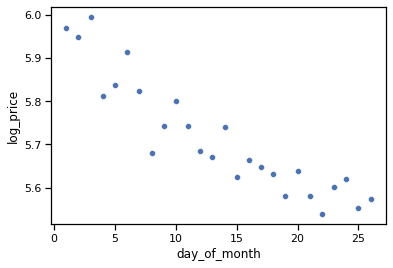

In [99]:
grouped= df.groupby('day_of_month')['log_price'].mean().reset_index()
sns.scatterplot(x='day_of_month', y='log_price', data=grouped);

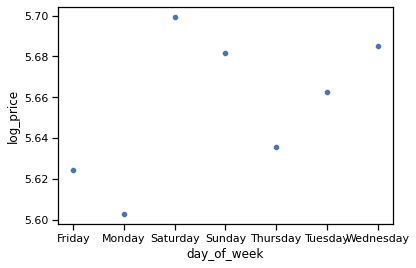

In [102]:
grouped= df.groupby('day_of_week')['log_price'].mean().reset_index()
sns.scatterplot(x='day_of_week', y='log_price', data=grouped);

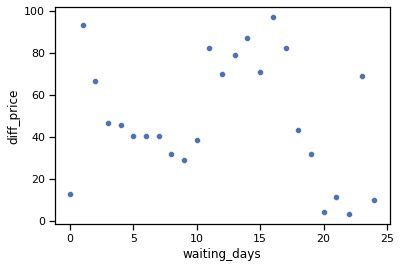

In [104]:
grouped= df.groupby('waiting_days')['diff_price'].mean().reset_index()
sns.scatterplot(x='waiting_days', y='diff_price', data=grouped);

In [106]:
corr_mat = df.corr()
corr_mat['waiting_days'].sort_values(ascending=False)

waiting_days      1.000000
buy               0.758443
days_until_dep    0.227134
day_of_month      0.111931
id                0.108266
diff_price        0.048699
direct            0.013055
price            -0.006705
hops             -0.012024
median_price     -0.025624
mean_price       -0.041483
log_price        -0.051823
distance         -0.054915
competition      -0.062073
fly_duration     -0.097169
Name: waiting_days, dtype: float64